# Homework #4: Subset Selection and Shrinkage Methods

## Background

In car sales, one of the most critical metrics is the number of days a vehicle spends on the lot. Some estimates suggest that every day a vehicle spends on the lot will cost the dealership ~$10/day in depreciation and maintenance. Multiply that by the hundreds (or thousands) of vehicles a dealership may hold in inventory and this quickly becomes one of the largest costs. A dataset provided by DriveTime, contains vehicle information as well as the number of days it spent on the lot, our task is to find any relationships that may explain the increase or decrease in days to sell.

### Relevant Datasets

`drive_time_sedans.csv`

Source: https://github.com/Fumanguyen/drivetime-sedans-used-vehicle-market/blob/master/drive_time_sedans.csv

## Task 1: Import the dataset and convert the categorical variables to dummy variables.

**Important Note**: The tasks below can be very computationally intensive. If you don't want to wait a long time for things to run or you don't feel your computer is powerful to complete these tasks in a reasonable time, I suggest dropping the `make.model`, `state`, and/or `makex` variables. Your grade will not be based on the inclusion or exclusion of any variables, I'm more interested in the methods but if you have the resources and are curious to explore more, feel free to use all variables.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
import time
import itertools
from scipy.special import binom

from sklearn.preprocessing import scale
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet
from sklearn.metrics import mean_squared_error
plt.style.use('seaborn-white')

In [2]:
df = pd.read_csv('drive_time_sedans.csv')
df.head()

,data.set,total.cost,lot.sale.days,overage,mileage,vehicle.type,domestic.import,vehicle.age,vehicle.age.group,color.set,makex,state,make.model
0,TRAIN,4037,135,YES,67341,FAMILY.LARGE,Domestic,8,SEVEN+,SILVER,BUICK,CA,BUICK.CENTURY
1,TRAIN,4662,18,NO,69384,FAMILY.SMALL,Import,4,FOUR,SILVER,MAZDA,TX,MAZDA.PROTEGE
2,TRAIN,4459,65,NO,58239,ECONOMY,Import,4,FOUR,RED,GEO,FL,GEO.METRO
3,TRAIN,4279,1,NO,58999,ECONOMY,Import,3,ONE-THREE,RED,KIA,TX,KIA.SEPHIA
4,TRAIN,4472,37,NO,47234,FAMILY.MEDIUM,Domestic,6,SIX,BLUE,MERCURY,NM,MERCURY.MYSTIQUE


In [3]:
print(df.shape)
df = df.dropna()
print(df.shape)
df = df.drop(['make.model','state','makex'], axis=1)
print(df.shape)

(17506, 13)
(17506, 13)
(17506, 10)


## Task 2: This dataset specifies which observations to use as train/test/validate. Split it into three dataframes based on these values.

If you've already converted those to dummy variables, you may have to subset slightly different. Search "*conditional subset pandas dataframe*" for a starting point or reach out to me (before the soft deadline) for guidance.

In [4]:
train = df[df['data.set'].isin(['TRAIN'])]
test = df[df['data.set'].isin(['TEST'])]
val = df[df['data.set'].isin(['VALIDATE'])]
print(train.head())
print(test.head())
print(val.head())

  data.set  total.cost  lot.sale.days overage  mileage   vehicle.type  \
0    TRAIN        4037            135     YES    67341   FAMILY.LARGE   
1    TRAIN        4662             18      NO    69384   FAMILY.SMALL   
2    TRAIN        4459             65      NO    58239        ECONOMY   
3    TRAIN        4279              1      NO    58999        ECONOMY   
4    TRAIN        4472             37      NO    47234  FAMILY.MEDIUM   

  domestic.import  vehicle.age vehicle.age.group color.set  
0        Domestic            8            SEVEN+    SILVER  
1          Import            4              FOUR    SILVER  
2          Import            4              FOUR       RED  
3          Import            3         ONE-THREE       RED  
4        Domestic            6               SIX      BLUE  
     data.set  total.cost  lot.sale.days overage  mileage   vehicle.type  \
8753     TEST        4995             13      NO    54837        ECONOMY   
8754     TEST        5595             24   

In [5]:
# I got get dummies after splitting the dataset to make things more simple
Xtrain = train[['total.cost', 'overage', 'mileage',
       'vehicle.type', 'domestic.import', 'vehicle.age', 'vehicle.age.group',
       'color.set']]
Xtrain = pd.get_dummies(data=Xtrain, drop_first=True)
ytrain = train[['lot.sale.days']]

In [6]:
val = val.drop(['data.set'], axis=1)
test = test.drop(['data.set'], axis=1)
val = pd.get_dummies(data=val, drop_first=True)
test = pd.get_dummies(data=test, drop_first=True)
yval = val['lot.sale.days']
yval = (yval-yval.mean())/yval.std()
ytest = test['lot.sale.days']
ytest = (ytest-ytest.mean())/ytest.std()
val = val.drop(['lot.sale.days'], axis=1)
test = test.drop(['lot.sale.days'], axis=1)
val = (val-val.mean())/val.std()
test = (test-test.mean())/test.std()

## Task 3: Normalize `total.cost`, `mileage`, and `vehicle.age`

In [7]:
Xtrain['total.cost'] = (Xtrain['total.cost']-Xtrain['total.cost'].mean())/Xtrain['total.cost'].std()
Xtrain['mileage'] = (Xtrain['mileage']-Xtrain['mileage'].mean())/Xtrain['mileage'].std()
Xtrain['vehicle.age'] = (Xtrain['vehicle.age']-Xtrain['vehicle.age'].mean())/Xtrain['vehicle.age'].std()
ytrain = (ytrain-ytrain.mean())/ytrain.std()
Xtrain.head()

,total.cost,mileage,vehicle.age,overage_YES,vehicle.type_FAMILY.LARGE,vehicle.type_FAMILY.MEDIUM,vehicle.type_FAMILY.SMALL,vehicle.type_LUXURY,domestic.import_Import,vehicle.age.group_FOUR,vehicle.age.group_ONE-THREE,vehicle.age.group_SEVEN+,vehicle.age.group_SIX,color.set_BLUE,color.set_GOLD,color.set_GREEN,color.set_PURPLE,color.set_RED,color.set_SILVER,color.set_WHITE
0,-0.909347,-0.564498,1.452244,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,-0.240259,-0.444185,-0.825291,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0
2,-0.457579,-1.100520,-0.825291,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
3,-0.650276,-1.055764,-1.394674,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
4,-0.443662,-1.748611,0.313476,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0


## Task 4: Use the code from the applied lecture to perform forward stepwise selection, with the single validation set from before (as opposed to cross-validation). Return not only the AIC, BIC, and Adjusted $R^2$, as was shown in the lecture, but also the MSE on the validation set. 

In [8]:
def processSubset(X, y, predictor_variables, response_variable):
    # Fit model on feature_set and calculate RSS
    
    model = sm.OLS(y,X[list(predictor_variables)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(predictor_variables)]) - y[response_variable]) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [9]:
def forward(X, y, predictors, response_variable):
    
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    t0 = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(X, y, predictors + [p], response_variable))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    t1 = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (t1-t0), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [10]:
models_fwd = pd.DataFrame(columns=["RSS", "model", "AIC", "BIC", "AdjR2"])

t0 = time.time()
predictors = []

for i in range(1,len(Xtrain.columns)+1):    
    models_fwd.loc[i] = forward(Xtrain, ytrain, predictors, 'lot.sale.days')
    predictors = models_fwd.loc[i]["model"].model.exog_names
    models_fwd.loc[i, 'AIC'] = models_fwd.loc[i, 'model'].aic
    models_fwd.loc[i, 'BIC'] = models_fwd.loc[i, 'model'].bic
    models_fwd.loc[i, 'AdjR2'] = models_fwd.loc[i, 'model'].rsquared_adj
    

t1 = time.time()
print("Total elapsed time:", (t1-t0), "seconds.")

Processed  20 models on 1 predictors in 0.09639358520507812 seconds.
Processed  19 models on 2 predictors in 0.08278656005859375 seconds.
Processed  18 models on 3 predictors in 0.08917522430419922 seconds.
Processed  17 models on 4 predictors in 0.07437968254089355 seconds.
Processed  16 models on 5 predictors in 0.0755012035369873 seconds.
Processed  15 models on 6 predictors in 0.08625578880310059 seconds.
Processed  14 models on 7 predictors in 0.10454797744750977 seconds.
Processed  13 models on 8 predictors in 0.09935283660888672 seconds.
Processed  12 models on 9 predictors in 0.10711526870727539 seconds.
Processed  11 models on 10 predictors in 0.07374334335327148 seconds.
Processed  10 models on 11 predictors in 0.07167387008666992 seconds.
Processed  9 models on 12 predictors in 0.07914590835571289 seconds.
Processed  8 models on 13 predictors in 0.06764793395996094 seconds.
Processed  7 models on 14 predictors in 0.08430957794189453 seconds.
Processed  6 models on 15 predict

In [11]:
models_fwd

,RSS,model,AIC,BIC,AdjR2
1,3774.447466,<statsmodels.regression.linear_model.Regressio...,17479.417717,17486.494869,0.568684
2,3376.202681,<statsmodels.regression.linear_model.Regressio...,16505.437257,16519.591561,0.614148
3,3095.367930,<statsmodels.regression.linear_model.Regressio...,15747.284436,15768.515891,0.646203
4,2858.017957,<statsmodels.regression.linear_model.Regressio...,15050.983966,15079.292573,0.673295
5,2751.899319,<statsmodels.regression.linear_model.Regressio...,14721.796461,14757.182220,0.685389
6,2638.579109,<statsmodels.regression.linear_model.Regressio...,14355.725994,14398.188905,0.698310
7,2579.403405,<statsmodels.regression.linear_model.Regressio...,14159.186753,14208.726815,0.705043
8,2488.019834,<statsmodels.regression.linear_model.Regressio...,13845.457403,13902.074617,0.715460
9,2481.622026,<statsmodels.regression.linear_model.Regressio...,13824.920551,13888.614917,0.716159
10,2472.565694,<statsmodels.regression.linear_model.Regressio...,13794.919275,13865.690793,0.717163


17


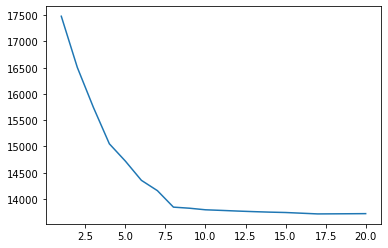

In [12]:
print(np.argmin(models_fwd['AIC']) + 1)
plt.plot(np.arange(len(models_fwd)) + 1,models_fwd['AIC'])

17


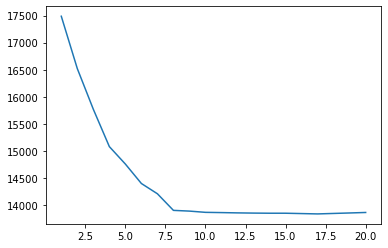

In [13]:
print(np.argmin(models_fwd['BIC']) + 1)
plt.plot(np.arange(len(models_fwd)) + 1,models_fwd['BIC'])

17


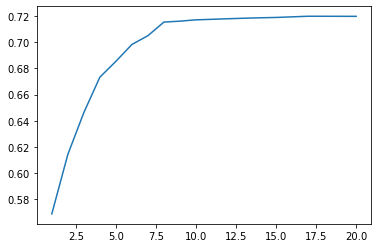

In [14]:
print(np.argmax(models_fwd['AdjR2'])+ 1)
plt.plot(np.arange(len(models_fwd)) + 1,models_fwd['AdjR2'])

In [22]:
models_fwd.loc[8,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          lot.sale.days   R-squared (uncentered):                   0.716
Model:                            OLS   Adj. R-squared (uncentered):              0.715
Method:                 Least Squares   F-statistic:                              2752.
Date:                Fri, 24 Jun 2022   Prob (F-statistic):                        0.00
Time:                        12:53:16   Log-Likelihood:                         -6914.7
No. Observations:                8753   AIC:                                  1.385e+04
Df Residuals:                    8745   BIC:                                  1.390e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
overage_YES                    1.9654      0.014    137.815      0.000       1.937       1.993
vehicle.type_FAMILY.MEDIUM    -0.3672      0.010    -37.264      0.000      -0.386      -0.348
domestic.import_Import        -0.0841      0.014     -6.050      0.000      -0.111      -0.057
vehicle.type_FAMILY.LARGE     -0.4623      0.014    -32.038      0.000      -0.491      -0.434
vehicle.type_FAMILY.SMALL     -0.3289      0.016    -20.964      0.000      -0.360      -0.298
vehicle.type_LUXURY           -0.4804      0.019    -25.210      0.000      -0.518      -0.443
vehicle.age                    0.1300      0.006     20.140      0.000       0.117       0.143
total.cost                     0.1124      0.006     17.922      0.000       0.100       0.125
==============================================================================
Omnibus:                     2024.326   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4714.493
Skew:                           1.299   Prob(JB):                         0.00
Kurtosis:                       5.486   Cond. No.                         4.51
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
val = val[['overage_YES','vehicle.type_FAMILY.MEDIUM','domestic.import_Import','vehicle.type_FAMILY.LARGE','vehicle.type_FAMILY.SMALL','vehicle.type_LUXURY','vehicle.age','total.cost']]

preds = models_fwd.loc[8,'model'].predict(val)
preds

13129   -0.843547
13130   -1.101572
13131   -0.959015
13132   -0.789062
13133   -1.243490
           ...   
17501   -0.412787
17502   -0.153711
17503   -0.629596
17504   -0.058958
17505   -0.980671
Length: 4377, dtype: float64

In [34]:
mse = np.mean(np.square(np.subtract(yval, preds)))
mse

1.7988251839789002

## Task 5: Using the code from the shrinkage methods lecture, find the optimal $\alpha$ and $\lambda$ for an Elastic Net regression using Cross-Validation.

Note: Remember that $\lambda$ is the argument `alpha` in scikit-learn and $\alpha$ is the `l1_ratio` argument. Sorry that nobody can settle on terminology.

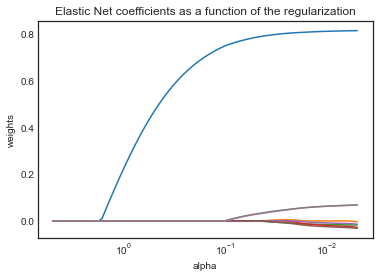

In [38]:
alphas = 10**np.linspace(1,-2,100)*0.5
l1_ratio = 0.5

en = ElasticNet(max_iter=10000)
coefs = []

for a in alphas:
    en.set_params(alpha=a, l1_ratio=l1_ratio)
    en.fit(scale(val), yval)
    coefs.append(en.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Elastic Net coefficients as a function of the regularization');

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(Xtrain)

In [53]:
folds = np.random.choice(a = 10, size = Xtrain.shape[0])
alphas = np.linspace(0.01,1,10)
l1_ratio = np.linspace(0.01,1,10)

mse_list = []
alpha_list = []
l1_list = []
for alpha in alphas:
    for l1 in l1_ratio:
        cv_list = []
        for i in range(10):
            val_folds_X = Xtrain.iloc[np.where(folds == i)]
            train_folds_X = Xtrain.iloc[np.where(folds != i)]

            val_folds_y = ytrain.iloc[np.where(folds == i)]
            train_folds_y = ytrain.iloc[np.where(folds != i)]

            encv = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=10000)
            encv.fit(scaler.transform(train_folds_X), train_folds_y)
            pred = encv.predict(scaler.transform(val_folds_X))
            cv_list.append(mean_squared_error(val_folds_y, pred))
        mse_list.append(np.mean(cv_list))
        alpha_list.append(alpha)
        l1_list.append(l1)

<AxesSubplot:xlabel='l1_ratio', ylabel='alpha'>

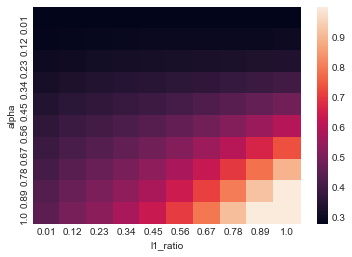

In [54]:
plotdata = pd.DataFrame({'alpha': alpha_list, 'l1_ratio': l1_list, 'mse': mse_list})
plot_data_pivoted = plotdata.pivot("alpha", "l1_ratio", "mse")
sns.heatmap(plot_data_pivoted)

In [55]:
opt_lambda = alpha_list[np.argmin(mse_list)]
opt_l1 = l1_list[np.argmin(mse_list)]
print(opt_lambda, opt_l1)

0.01 0.12


In [47]:
opt_en = ElasticNet()
opt_en.set_params(alpha=opt_lambda, l1_ratio=opt_l1, max_iter=10000)
opt_en.fit(scaler.transform(Xtrain), ytrain)
mean_squared_error(ytest, opt_en.predict(scaler.transform(test)))

1.9040598677203582

In [52]:
df = df[['total.cost', 'overage', 'mileage',
       'vehicle.type', 'domestic.import', 'vehicle.age', 'vehicle.age.group',
       'color.set']]
df = pd.get_dummies(data=df, drop_first=True)
pd.Series(opt_en.coef_.flatten(), index=df.columns)

total.cost                     0.086776
mileage                       -0.007504
vehicle.age                    0.041396
overage_YES                    0.805496
vehicle.type_FAMILY.LARGE     -0.060736
vehicle.type_FAMILY.MEDIUM    -0.047465
vehicle.type_FAMILY.SMALL     -0.033954
vehicle.type_LUXURY           -0.073022
domestic.import_Import        -0.008086
vehicle.age.group_FOUR        -0.018124
vehicle.age.group_ONE-THREE   -0.022909
vehicle.age.group_SEVEN+       0.043479
vehicle.age.group_SIX          0.023306
color.set_BLUE                 0.030045
color.set_GOLD                -0.001521
color.set_GREEN                0.006866
color.set_PURPLE               0.008121
color.set_RED                  0.015911
color.set_SILVER               0.003949
color.set_WHITE                0.024868
dtype: float64

## Question: Given all of the results you've found, which model would you choose and why? Hint: There is no right answer but you will need to justify any answer you give.